## Реализация дерева решений

Реализуем алгоритм алгоритм работы дерева решений своими руками.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [3]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        #  найдем среднее значение    
        prediction = np.mean(self.labels)
        return prediction        

In [4]:
# Расчет критерия информативности (дисперсии)

def variaty(labels):
    variaty = np.var(labels)           
    return variaty

In [5]:
# Расчет критерия информативности (дисперсия)

def quality(left_labels, right_labels, current_var):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_var - p * variaty(left_labels) - (1 - p) * variaty(right_labels)

In [6]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [7]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 2

    current_var = variaty(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_var)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [8]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels):
          
    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    
    return Node(index, t, true_branch, false_branch)

In [9]:
def build(data, labels):
    
    global count
    count = 0
    
    def tree(data, labels):

        global count

        count += 1

        quality, t, index = find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качестве или количество разбиений превышает порог
        if (quality == 0) or (count > 550):
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

        
        # Рекурсивно строим два поддерева
        true_branch = tree(true_data, true_labels)
        false_branch = tree(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева

        return Node(index, t, true_branch, false_branch)
    
    return tree(data, labels)   

In [10]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [11]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [12]:
# сгенерируем данные
classification_data, classification_labels, coef = datasets.make_regression(n_samples=1000, n_features = 2, n_informative = 2, n_targets = 1, 
                                              noise = 5, coef = True, random_state = 2)

In [13]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [14]:
my_tree = build_tree(train_data, train_labels)

In [15]:
my_tree_new = build(train_data, train_labels)

In [16]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [17]:
print_tree(my_tree)

Индекс 1
Порог 0.26448360406258725
--> True:
  Индекс 0
  Порог 0.132924055186507
  --> True:
    Индекс 1
    Порог -1.1648113258867563
    --> True:
      Индекс 0
      Порог -1.8532888650882562
      --> True:
        Индекс 0
        Порог -2.2000219885513803
        --> True:
          Индекс 0
          Порог -2.515439456144192
          --> True:
            Прогноз: -293.00224002669825
          --> False:
            Прогноз: -276.9252833949262
        --> False:
          Прогноз: -224.31436154824587
      --> False:
        Индекс 1
        Порог -1.7934355851948631
        --> True:
          Индекс 0
          Порог -0.4151419697731788
          --> True:
            Индекс 1
            Порог -2.4131383417363272
            --> True:
              Индекс 0
              Порог -0.7127046039164141
              --> True:
                Прогноз: -244.19070330860922
              --> False:
                Прогноз: -192.99416954092194
            --> False:
              Ин

In [18]:
print_tree(my_tree_new)

Индекс 1
Порог 0.26448360406258725
--> True:
  Индекс 0
  Порог 0.132924055186507
  --> True:
    Индекс 1
    Порог -1.1648113258867563
    --> True:
      Индекс 0
      Порог -1.8532888650882562
      --> True:
        Индекс 0
        Порог -2.2000219885513803
        --> True:
          Индекс 0
          Порог -2.515439456144192
          --> True:
            Прогноз: -293.00224002669825
          --> False:
            Прогноз: -276.9252833949262
        --> False:
          Прогноз: -224.31436154824587
      --> False:
        Индекс 1
        Порог -1.7934355851948631
        --> True:
          Индекс 0
          Порог -0.4151419697731788
          --> True:
            Индекс 1
            Порог -2.4131383417363272
            --> True:
              Индекс 0
              Порог -0.7127046039164141
              --> True:
                Прогноз: -244.19070330860922
              --> False:
                Прогноз: -192.99416954092194
            --> False:
              Ин

                  Индекс 1
                  Порог 0.2529459259222099
                  --> True:
                    Индекс 1
                    Порог 0.13903252680171282
                    --> True:
                      Индекс 1
                      Порог 0.020505118896650996
                      --> True:
                        Прогноз: -69.15275867747437
                      --> False:
                        Прогноз: -62.835273446550545
                    --> False:
                      Прогноз: -71.75636408859776
                  --> False:
                    Прогноз: -61.245288654273764
              --> False:
                Индекс 1
                Порог -0.061635084622049585
                --> True:
                  Прогноз: -67.46238211819747
                --> False:
                  Индекс 1
                  Порог 0.05973095330143845
                  --> True:
                    Прогноз: -56.76767134866731
                  --> False:
                   

In [19]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [20]:
# Получим ответы для обучающей выборки 
train_answers_new = predict(train_data, my_tree_new)
# И получим ответы для тестовой выборки
answers_new = predict(test_data, my_tree_new)

In [21]:
# Введем функцию подсчета точности 
from sklearn.metrics import r2_score as r2
import seaborn as sns

def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(9,5))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

***Дерево решений для задачи регрессии***

Train R2:	0.996
Test R2:	0.972


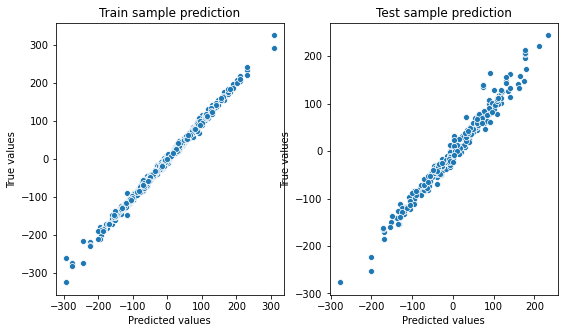

In [22]:
evaluate_preds(train_labels, train_answers, test_labels, answers)

***Дерево решений с ограничением на количство разбиений***

Train R2:	0.987
Test R2:	0.962


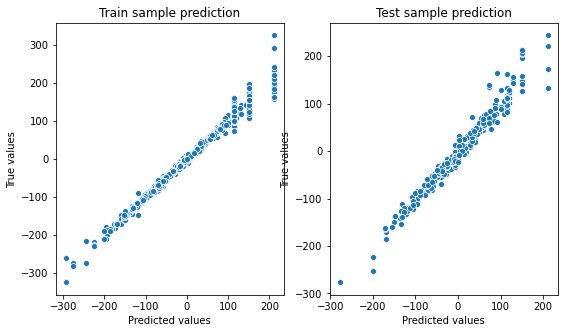

In [23]:
evaluate_preds(train_labels, train_answers_new, test_labels, answers_new)

***Сравним с линейной регрессией***

In [24]:
from sklearn import linear_model

# создадим модель
linear_regressor = linear_model.LinearRegression()

# обучим ее
linear_regressor.fit(train_data, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
lr_test=linear_regressor.predict(test_data)
lr_train=linear_regressor.predict(train_data)

Train R2:	0.997
Test R2:	0.996


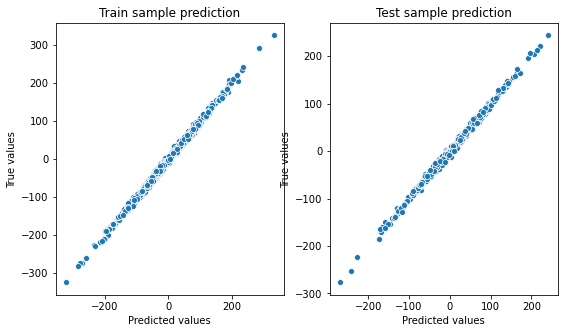

In [26]:
evaluate_preds(train_labels, lr_train, test_labels, lr_test)

***Сравним с деревом решений из sklearn***

In [27]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
dt.fit(train_data, train_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [28]:
dt_test = dt.predict(test_data)
dt_train = dt.predict(train_data)

Train R2:	1.0
Test R2:	0.974


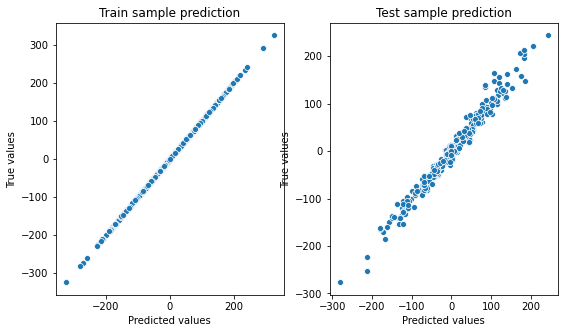

In [29]:
evaluate_preds(train_labels, dt_train, test_labels, dt_test)